In [4]:
import pickle
import math

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

In [7]:
#NHWC [batch, height, weight, class]
features = np.empty((0,32,32,3))
labels = np.array([])

In [8]:
for i in range(5):
    with open('cifar_10/data_batch_'+str(i+1), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    #NCHW --> NHWC    
    batch_images = batch['data'].reshape((len(batch['data']),3,32,32))
    batch_images = batch_images.transpose(0,2,3,1)
    
    features = np.append(features, batch_images, axis=0)
    
    batch_labels = np.array(batch['labels'])
    
    labels = np.append(labels, batch_labels, axis=0)    
    

In [9]:
features.shape

(50000, 32, 32, 3)

In [10]:
labels.shape

(50000,)

In [11]:
classes=['airplanes',
        'automobile',
        'bird',
        'cat',
        'deer',
        'dog',
        'frog',
        'horse',
        'ship',
        'truck']

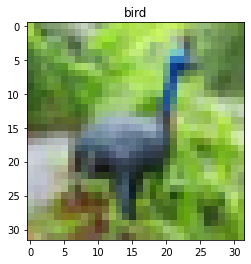

In [13]:
one_label = classes[int(labels[6])]
one_image = np.clip(features[6], 0, 255).astype(np.int32)

plt.title(one_label)
plt.imshow(one_image)

In [15]:
train_size = int(len(features) * 0.8)

In [16]:
X_train = features[:train_size,:,:]
Y_train = labels[:train_size]

X_test = features[train_size:,:,:]
Y_test = labels[train_size:]

In [17]:
print(X_train.shape, X_test.shape)

(40000, 32, 32, 3) (10000, 32, 32, 3)


In [18]:
print(Y_train.shape, Y_test.shape)

(40000,) (10000,)


In [19]:
height = 32
width = 32
channels = 3
n_inputs = height * width

In [21]:
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

In [24]:
X = tf.compat.v1.placeholder(tf.float32, shape=[None, height, width, channels], name="X")

In [29]:
dropout_rate = 0.4

training = tf.compat.v1.placeholder_with_default(False, shape=(), name="training")
dropout_1 = tf.compat.v1.layers.dropout(X, dropout_rate, training=training)

In [30]:
y = tf.compat.v1.placeholder(tf.int32, shape=[None], name='y')

In [31]:
conv_1 = tf.compat.v1.layers.conv2d(dropout_1,
                                   filters=32,
                                   kernel_size=3,
                                   strides=1,
                                   padding="SAME",
                                   activation=tf.nn.relu, 
                                   name="conv_1")

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\convolutional.py:414: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  warnings.warn('`tf.layers.conv2d` is deprecated and '


In [32]:
conv_2 = tf.compat.v1.layers.conv2d(conv_1,
                                   filters = 64,
                                   kernel_size=3,
                                   strides=2,
                                   padding="SAME",
                                   activation=tf.nn.relu,
                                   name="conv_2"
                        )

In [33]:
pool_3=tf.nn.max_pool(conv_2,
                     ksize=[1,2,2,1],
                     strides=[1,2,2,1],
                     padding="VALID")

In [34]:
conv_4 = tf.compat.v1.layers.conv2d(pool_3,
                                    filters=128,
                                    kernel_size=4,
                                    strides=3,
                                    padding="SAME",
                                    activation=tf.nn.relu,
                                    name="conv4"
                                )

c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\legacy_tf_layers\convolutional.py:414: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  warnings.warn('`tf.layers.conv2d` is deprecated and '
c:\users\admin\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [35]:
pool_5=tf.nn.max_pool(conv_4,
                     ksize=[1,2,2,1],
                     strides=[1,1,1,1],
                     padding="VALID")

pool_5_flat = tf.reshape(pool_5, shape=[-1, 128*2*2])

In [39]:
fullyconn_1 = tf.compat.v1.layers.dense(pool_5_flat,
                             128,
                             activation = tf.nn.relu,
                             name="fc1")

ValueError: Variable fc1/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope?

In [41]:
fullyconn_2 = tf.compat.v1.layers.dense(fullyconn_1,
                             63,
                             activation=tf.nn.relu,
                             name="fc2")

In [42]:
output = tf.compat.v1.layers.dense(fullyconn_2, 10, name="output")

In [44]:
x_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=output,
                                                          labels=y)

loss = tf.reduce_mean(x_entropy)
optimizer = tf.compat.v1.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

In [51]:
correct = tf.compat.v1.nn.in_top_k(output, y, 1)
accuracy = tf.compat.v1.reduce_mean(tf.cast(correct, tf.float32))

In [53]:
init = tf.compat.v1.global_variables_initializer()

In [ ]:
n_epochs = 10

_BATCH_SIZE = 256

with tf.compat.v1.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        batch_size = int(math.ceil(len(X_train) / _BATCH_SIZE))
        
        for s in range(batch_size):
            batch_xs = X_train[s * _BATCH_SIZE : (s+1) * _BATCH_SIZE]
            batch_ys = Y_train[s * _BATCH_SIZE : (s+1) * _BATCH_SIZE]
            
            sess.run(training_op, feed_dict={X: batch_xs, y: batch_ys, training:True})
        
        acc_train = accuracy.eval(feed_dict = {X: X_train, y : Y_train})
        acc_test = accuracy.eval(feed_dict = {X:X_test, y: Y_test})
        
        print(epoch, "Train accuracy:", acc_train, "Test accuracy", acc_test)